<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/vgg5_with_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data for 2/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data for 2/X_test.npy')
X_val = np.load('/content/drive/MyDrive/data for 2/X_val.npy')
Y_train = np.load('/content/drive/MyDrive/data for 2/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data for 2/Y_test.npy')
Y_val = np.load('/content/drive/MyDrive/data for 2/Y_val.npy')
label = np.load('/content/drive/MyDrive/data for 2/label.npy')

### Check if have any missing data

In [4]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((61122, 32, 32),
 (19168, 32, 32),
 (15281, 32, 32),
 (61122, 2),
 (19168, 2),
 (15281, 2))

In [5]:
X_train[0]

array([[0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       [0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       [0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       ...,
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824]], dtype=float32)

In [6]:
X_val[0]

array([[0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       ...,
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824]], dtype=float32)

In [7]:
Y_train[0]

array([0., 1.])

### Model and Train

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [10]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.models import Model
import tensorflow as tf

class VGG5(Model):
    def __init__(self, num_classes, **kwargs):
        """
        num_classes: number of classes in specific classification task
        """
        super().__init__(**kwargs)

        # Define the convolutional layers with Batch Normalization
        self.conv1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn2 = BatchNormalization()
        self.pool1 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')

        self.conv3 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn3 = BatchNormalization()
        self.conv4 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn4 = BatchNormalization()
        self.pool2 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')

        self.conv5 = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn5 = BatchNormalization()
        self.pool3 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')

        # Define the fully connected layers with Batch Normalization
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.bn_fc1 = BatchNormalization()
        self.fc2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        out = self.conv1(inputs)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.pool1(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.pool2(out)

        out = self.conv5(out)
        out = self.bn5(out)
        out = self.pool3(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.bn_fc1(out)
        out = self.fc2(out)

        return out



In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [12]:
model = VGG5(2)
model.build(input_shape = (None, 32, 32, 1))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Model: "vgg5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  640       
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           multiple                  36928     
                                                                 
 batch_normalization_1 (Bat  multiple                  256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                              

In [13]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
239/238 [==============================] - ETA: 0s - loss: 0.5158 - accuracy: 0.7652 - f1_m: 0.7652 - precision_m: 0.7652 - recall_m: 0.7652

238/238 [==============================] - 44s 135ms/step - loss: 0.5158 - accuracy: 0.7652 - f1_m: 0.7652 - precision_m: 0.7652 - recall_m: 0.7652 - val_loss: 0.7458 - val_accuracy: 0.5801 - val_f1_m: 0.5802 - val_precision_m: 0.5802 - val_recall_m: 0.5802
Epoch 2/50
239/238 [==============================] - ETA: 0s - loss: 0.3328 - accuracy: 0.8494 - f1_m: 0.8493 - precision_m: 0.8493 - recall_m: 0.8493

238/238 [==============================] - 23s 97ms/step - loss: 0.3328 - accuracy: 0.8494 - f1_m: 0.8493 - precision_m: 0.8493 - recall_m: 0.8493 - val_loss: 0.3029 - val_accuracy: 0.8653 - val_f1_m: 0.8652 - val_precision_m: 0.8652 - val_recall_m: 0.8652
Epoch 3/50
239/238 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.8710 - f1_m: 0.8710 - precision_m: 0.8710 - recall_m: 0.8710

238/238 [==============================] - 27s 111ms/step - loss: 0.2907 - accuracy: 0.8710 - f1_m: 0.8710 - precision_m: 0.8710 - recall_m: 0.8710 - val_loss: 0.3347 - val_accuracy: 0.8497 - val_f1_m: 0.8495 - val_precision_m: 0.8495 - val_recall_m: 0.8495
Epoch 4/50
239/238 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.8837 - f1_m: 0.8837 - precision_m: 0.8837 - recall_m: 0.8837

238/238 [==============================] - 24s 98ms/step - loss: 0.2667 - accuracy: 0.8837 - f1_m: 0.8837 - precision_m: 0.8837 - recall_m: 0.8837 - val_loss: 0.3860 - val_accuracy: 0.8375 - val_f1_m: 0.8373 - val_precision_m: 0.8373 - val_recall_m: 0.8373
Epoch 5/50
239/238 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.8868 - f1_m: 0.8867 - precision_m: 0.8867 - recall_m: 0.8867

238/238 [==============================] - 24s 102ms/step - loss: 0.2582 - accuracy: 0.8868 - f1_m: 0.8867 - precision_m: 0.8867 - recall_m: 0.8867 - val_loss: 0.2659 - val_accuracy: 0.8831 - val_f1_m: 0.8831 - val_precision_m: 0.8831 - val_recall_m: 0.8831
Epoch 6/50
239/238 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.8957 - f1_m: 0.8957 - precision_m: 0.8957 - recall_m: 0.8957

238/238 [==============================] - 23s 96ms/step - loss: 0.2408 - accuracy: 0.8957 - f1_m: 0.8957 - precision_m: 0.8957 - recall_m: 0.8957 - val_loss: 0.2433 - val_accuracy: 0.8951 - val_f1_m: 0.8950 - val_precision_m: 0.8950 - val_recall_m: 0.8950
Epoch 7/50
239/238 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9033 - f1_m: 0.9033 - precision_m: 0.9033 - recall_m: 0.9033

238/238 [==============================] - 24s 101ms/step - loss: 0.2250 - accuracy: 0.9033 - f1_m: 0.9033 - precision_m: 0.9033 - recall_m: 0.9033 - val_loss: 0.2361 - val_accuracy: 0.9019 - val_f1_m: 0.9019 - val_precision_m: 0.9019 - val_recall_m: 0.9019
Epoch 8/50
239/238 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9088 - f1_m: 0.9088 - precision_m: 0.9088 - recall_m: 0.9088

238/238 [==============================] - 23s 97ms/step - loss: 0.2119 - accuracy: 0.9088 - f1_m: 0.9088 - precision_m: 0.9088 - recall_m: 0.9088 - val_loss: 0.2571 - val_accuracy: 0.8916 - val_f1_m: 0.8915 - val_precision_m: 0.8915 - val_recall_m: 0.8915
Epoch 9/50
239/238 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9123 - f1_m: 0.9123 - precision_m: 0.9123 - recall_m: 0.9123

238/238 [==============================] - 25s 103ms/step - loss: 0.2038 - accuracy: 0.9123 - f1_m: 0.9123 - precision_m: 0.9123 - recall_m: 0.9123 - val_loss: 0.2464 - val_accuracy: 0.8973 - val_f1_m: 0.8971 - val_precision_m: 0.8971 - val_recall_m: 0.8971
Epoch 10/50
239/238 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9164 - f1_m: 0.9164 - precision_m: 0.9164 - recall_m: 0.9164

238/238 [==============================] - 25s 106ms/step - loss: 0.1952 - accuracy: 0.9164 - f1_m: 0.9164 - precision_m: 0.9164 - recall_m: 0.9164 - val_loss: 0.2108 - val_accuracy: 0.9089 - val_f1_m: 0.9090 - val_precision_m: 0.9090 - val_recall_m: 0.9090
Epoch 11/50
239/238 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9212 - f1_m: 0.9212 - precision_m: 0.9212 - recall_m: 0.9212

238/238 [==============================] - 25s 103ms/step - loss: 0.1841 - accuracy: 0.9212 - f1_m: 0.9212 - precision_m: 0.9212 - recall_m: 0.9212 - val_loss: 0.2528 - val_accuracy: 0.8961 - val_f1_m: 0.8961 - val_precision_m: 0.8961 - val_recall_m: 0.8961
Epoch 12/50
239/238 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9249 - f1_m: 0.9248 - precision_m: 0.9248 - recall_m: 0.9248

238/238 [==============================] - 25s 105ms/step - loss: 0.1767 - accuracy: 0.9249 - f1_m: 0.9248 - precision_m: 0.9248 - recall_m: 0.9248 - val_loss: 0.1933 - val_accuracy: 0.9178 - val_f1_m: 0.9178 - val_precision_m: 0.9178 - val_recall_m: 0.9178
Epoch 13/50
239/238 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9269 - f1_m: 0.9269 - precision_m: 0.9269 - recall_m: 0.9269

238/238 [==============================] - 24s 99ms/step - loss: 0.1737 - accuracy: 0.9269 - f1_m: 0.9269 - precision_m: 0.9269 - recall_m: 0.9269 - val_loss: 0.2281 - val_accuracy: 0.9078 - val_f1_m: 0.9077 - val_precision_m: 0.9077 - val_recall_m: 0.9077
Epoch 14/50
239/238 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9303 - f1_m: 0.9303 - precision_m: 0.9303 - recall_m: 0.9303

238/238 [==============================] - 24s 102ms/step - loss: 0.1644 - accuracy: 0.9303 - f1_m: 0.9303 - precision_m: 0.9303 - recall_m: 0.9303 - val_loss: 0.2267 - val_accuracy: 0.9004 - val_f1_m: 0.9005 - val_precision_m: 0.9005 - val_recall_m: 0.9005
Epoch 15/50
239/238 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9343 - f1_m: 0.9343 - precision_m: 0.9343 - recall_m: 0.9343

238/238 [==============================] - 23s 95ms/step - loss: 0.1581 - accuracy: 0.9343 - f1_m: 0.9343 - precision_m: 0.9343 - recall_m: 0.9343 - val_loss: 0.1840 - val_accuracy: 0.9221 - val_f1_m: 0.9220 - val_precision_m: 0.9220 - val_recall_m: 0.9220
Epoch 16/50
239/238 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9363 - f1_m: 0.9363 - precision_m: 0.9363 - recall_m: 0.9363

238/238 [==============================] - 23s 98ms/step - loss: 0.1528 - accuracy: 0.9363 - f1_m: 0.9363 - precision_m: 0.9363 - recall_m: 0.9363 - val_loss: 0.2154 - val_accuracy: 0.9160 - val_f1_m: 0.9160 - val_precision_m: 0.9160 - val_recall_m: 0.9160
Epoch 17/50
239/238 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9399 - f1_m: 0.9399 - precision_m: 0.9399 - recall_m: 0.9399

238/238 [==============================] - 24s 100ms/step - loss: 0.1475 - accuracy: 0.9399 - f1_m: 0.9399 - precision_m: 0.9399 - recall_m: 0.9399 - val_loss: 0.2461 - val_accuracy: 0.9030 - val_f1_m: 0.9031 - val_precision_m: 0.9031 - val_recall_m: 0.9031
Epoch 18/50
239/238 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9407 - f1_m: 0.9407 - precision_m: 0.9407 - recall_m: 0.9407

238/238 [==============================] - 23s 95ms/step - loss: 0.1450 - accuracy: 0.9407 - f1_m: 0.9407 - precision_m: 0.9407 - recall_m: 0.9407 - val_loss: 0.1905 - val_accuracy: 0.9208 - val_f1_m: 0.9208 - val_precision_m: 0.9208 - val_recall_m: 0.9208
Epoch 19/50
239/238 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9428 - f1_m: 0.9428 - precision_m: 0.9428 - recall_m: 0.9428

238/238 [==============================] - 25s 105ms/step - loss: 0.1374 - accuracy: 0.9428 - f1_m: 0.9428 - precision_m: 0.9428 - recall_m: 0.9428 - val_loss: 0.2129 - val_accuracy: 0.9152 - val_f1_m: 0.9152 - val_precision_m: 0.9152 - val_recall_m: 0.9152
Epoch 20/50
239/238 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9449 - f1_m: 0.9449 - precision_m: 0.9449 - recall_m: 0.9449

238/238 [==============================] - 25s 104ms/step - loss: 0.1354 - accuracy: 0.9449 - f1_m: 0.9449 - precision_m: 0.9449 - recall_m: 0.9449 - val_loss: 0.2003 - val_accuracy: 0.9217 - val_f1_m: 0.9217 - val_precision_m: 0.9217 - val_recall_m: 0.9217
Epoch 21/50
239/238 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9471 - f1_m: 0.9471 - precision_m: 0.9471 - recall_m: 0.9471

238/238 [==============================] - 23s 97ms/step - loss: 0.1296 - accuracy: 0.9471 - f1_m: 0.9471 - precision_m: 0.9471 - recall_m: 0.9471 - val_loss: 0.1687 - val_accuracy: 0.9314 - val_f1_m: 0.9313 - val_precision_m: 0.9313 - val_recall_m: 0.9313
Epoch 22/50
239/238 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9512 - f1_m: 0.9511 - precision_m: 0.9511 - recall_m: 0.9511

238/238 [==============================] - 24s 101ms/step - loss: 0.1237 - accuracy: 0.9512 - f1_m: 0.9511 - precision_m: 0.9511 - recall_m: 0.9511 - val_loss: 0.1541 - val_accuracy: 0.9365 - val_f1_m: 0.9364 - val_precision_m: 0.9364 - val_recall_m: 0.9364
Epoch 23/50
239/238 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9498 - f1_m: 0.9498 - precision_m: 0.9498 - recall_m: 0.9498

238/238 [==============================] - 23s 97ms/step - loss: 0.1240 - accuracy: 0.9498 - f1_m: 0.9498 - precision_m: 0.9498 - recall_m: 0.9498 - val_loss: 0.1645 - val_accuracy: 0.9349 - val_f1_m: 0.9350 - val_precision_m: 0.9350 - val_recall_m: 0.9350
Epoch 24/50
239/238 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9534 - f1_m: 0.9534 - precision_m: 0.9534 - recall_m: 0.9534

238/238 [==============================] - 25s 104ms/step - loss: 0.1154 - accuracy: 0.9534 - f1_m: 0.9534 - precision_m: 0.9534 - recall_m: 0.9534 - val_loss: 0.1726 - val_accuracy: 0.9306 - val_f1_m: 0.9308 - val_precision_m: 0.9308 - val_recall_m: 0.9308
Epoch 25/50
239/238 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.9542 - f1_m: 0.9542 - precision_m: 0.9542 - recall_m: 0.9542

238/238 [==============================] - 25s 106ms/step - loss: 0.1144 - accuracy: 0.9542 - f1_m: 0.9542 - precision_m: 0.9542 - recall_m: 0.9542 - val_loss: 0.1521 - val_accuracy: 0.9384 - val_f1_m: 0.9385 - val_precision_m: 0.9385 - val_recall_m: 0.9385
Epoch 26/50
239/238 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9555 - f1_m: 0.9555 - precision_m: 0.9555 - recall_m: 0.9555

238/238 [==============================] - 25s 104ms/step - loss: 0.1107 - accuracy: 0.9555 - f1_m: 0.9555 - precision_m: 0.9555 - recall_m: 0.9555 - val_loss: 0.1609 - val_accuracy: 0.9373 - val_f1_m: 0.9373 - val_precision_m: 0.9373 - val_recall_m: 0.9373
Epoch 27/50
239/238 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9588 - f1_m: 0.9588 - precision_m: 0.9588 - recall_m: 0.9588

238/238 [==============================] - 25s 105ms/step - loss: 0.1045 - accuracy: 0.9588 - f1_m: 0.9588 - precision_m: 0.9588 - recall_m: 0.9588 - val_loss: 0.1723 - val_accuracy: 0.9355 - val_f1_m: 0.9355 - val_precision_m: 0.9355 - val_recall_m: 0.9355
Epoch 28/50
239/238 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9599 - f1_m: 0.9599 - precision_m: 0.9599 - recall_m: 0.9599

238/238 [==============================] - 23s 98ms/step - loss: 0.1015 - accuracy: 0.9599 - f1_m: 0.9599 - precision_m: 0.9599 - recall_m: 0.9599 - val_loss: 0.1999 - val_accuracy: 0.9242 - val_f1_m: 0.9243 - val_precision_m: 0.9243 - val_recall_m: 0.9243
Epoch 29/50
239/238 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9606 - f1_m: 0.9606 - precision_m: 0.9606 - recall_m: 0.9606

238/238 [==============================] - 25s 105ms/step - loss: 0.0985 - accuracy: 0.9606 - f1_m: 0.9606 - precision_m: 0.9606 - recall_m: 0.9606 - val_loss: 0.1487 - val_accuracy: 0.9440 - val_f1_m: 0.9442 - val_precision_m: 0.9442 - val_recall_m: 0.9442
Epoch 30/50
239/238 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9615 - f1_m: 0.9615 - precision_m: 0.9615 - recall_m: 0.9615

238/238 [==============================] - 25s 103ms/step - loss: 0.0964 - accuracy: 0.9615 - f1_m: 0.9615 - precision_m: 0.9615 - recall_m: 0.9615 - val_loss: 0.1560 - val_accuracy: 0.9400 - val_f1_m: 0.9400 - val_precision_m: 0.9400 - val_recall_m: 0.9400
Epoch 31/50
239/238 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9631 - f1_m: 0.9632 - precision_m: 0.9632 - recall_m: 0.9632

238/238 [==============================] - 25s 103ms/step - loss: 0.0947 - accuracy: 0.9631 - f1_m: 0.9632 - precision_m: 0.9632 - recall_m: 0.9632 - val_loss: 0.1717 - val_accuracy: 0.9346 - val_f1_m: 0.9346 - val_precision_m: 0.9346 - val_recall_m: 0.9346
Epoch 32/50
239/238 [==============================] - ETA: 0s - loss: 0.0911 - accuracy: 0.9639 - f1_m: 0.9639 - precision_m: 0.9639 - recall_m: 0.9639

238/238 [==============================] - 25s 104ms/step - loss: 0.0911 - accuracy: 0.9639 - f1_m: 0.9639 - precision_m: 0.9639 - recall_m: 0.9639 - val_loss: 0.1697 - val_accuracy: 0.9365 - val_f1_m: 0.9365 - val_precision_m: 0.9365 - val_recall_m: 0.9365
Epoch 33/50
239/238 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9657 - f1_m: 0.9657 - precision_m: 0.9657 - recall_m: 0.9657

238/238 [==============================] - 24s 99ms/step - loss: 0.0874 - accuracy: 0.9657 - f1_m: 0.9657 - precision_m: 0.9657 - recall_m: 0.9657 - val_loss: 0.1880 - val_accuracy: 0.9329 - val_f1_m: 0.9330 - val_precision_m: 0.9330 - val_recall_m: 0.9330
Epoch 34/50
239/238 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9668 - f1_m: 0.9668 - precision_m: 0.9668 - recall_m: 0.9668

238/238 [==============================] - 24s 101ms/step - loss: 0.0855 - accuracy: 0.9668 - f1_m: 0.9668 - precision_m: 0.9668 - recall_m: 0.9668 - val_loss: 0.1675 - val_accuracy: 0.9378 - val_f1_m: 0.9379 - val_precision_m: 0.9379 - val_recall_m: 0.9379
Epoch 35/50
239/238 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9668 - f1_m: 0.9668 - precision_m: 0.9668 - recall_m: 0.9668

238/238 [==============================] - 25s 103ms/step - loss: 0.0843 - accuracy: 0.9668 - f1_m: 0.9668 - precision_m: 0.9668 - recall_m: 0.9668 - val_loss: 0.1599 - val_accuracy: 0.9414 - val_f1_m: 0.9413 - val_precision_m: 0.9413 - val_recall_m: 0.9413
Epoch 36/50
239/238 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9693 - f1_m: 0.9693 - precision_m: 0.9693 - recall_m: 0.9693

238/238 [==============================] - 25s 104ms/step - loss: 0.0793 - accuracy: 0.9693 - f1_m: 0.9693 - precision_m: 0.9693 - recall_m: 0.9693 - val_loss: 0.1485 - val_accuracy: 0.9455 - val_f1_m: 0.9456 - val_precision_m: 0.9456 - val_recall_m: 0.9456
Epoch 37/50
239/238 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9701 - f1_m: 0.9701 - precision_m: 0.9701 - recall_m: 0.9701

238/238 [==============================] - 25s 103ms/step - loss: 0.0767 - accuracy: 0.9701 - f1_m: 0.9701 - precision_m: 0.9701 - recall_m: 0.9701 - val_loss: 0.1397 - val_accuracy: 0.9516 - val_f1_m: 0.9517 - val_precision_m: 0.9517 - val_recall_m: 0.9517
Epoch 38/50
239/238 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9702 - f1_m: 0.9702 - precision_m: 0.9702 - recall_m: 0.9702

238/238 [==============================] - 23s 98ms/step - loss: 0.0777 - accuracy: 0.9702 - f1_m: 0.9702 - precision_m: 0.9702 - recall_m: 0.9702 - val_loss: 0.1656 - val_accuracy: 0.9444 - val_f1_m: 0.9445 - val_precision_m: 0.9445 - val_recall_m: 0.9445
Epoch 39/50
239/238 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9718 - f1_m: 0.9719 - precision_m: 0.9719 - recall_m: 0.9719

238/238 [==============================] - 25s 103ms/step - loss: 0.0708 - accuracy: 0.9718 - f1_m: 0.9719 - precision_m: 0.9719 - recall_m: 0.9719 - val_loss: 0.1601 - val_accuracy: 0.9422 - val_f1_m: 0.9423 - val_precision_m: 0.9423 - val_recall_m: 0.9423
Epoch 40/50
239/238 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9722 - f1_m: 0.9722 - precision_m: 0.9722 - recall_m: 0.9722

238/238 [==============================] - 25s 104ms/step - loss: 0.0718 - accuracy: 0.9722 - f1_m: 0.9722 - precision_m: 0.9722 - recall_m: 0.9722 - val_loss: 0.1705 - val_accuracy: 0.9383 - val_f1_m: 0.9383 - val_precision_m: 0.9383 - val_recall_m: 0.9383
Epoch 41/50
239/238 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9728 - f1_m: 0.9728 - precision_m: 0.9728 - recall_m: 0.9728

238/238 [==============================] - 24s 100ms/step - loss: 0.0704 - accuracy: 0.9728 - f1_m: 0.9728 - precision_m: 0.9728 - recall_m: 0.9728 - val_loss: 0.1921 - val_accuracy: 0.9312 - val_f1_m: 0.9312 - val_precision_m: 0.9312 - val_recall_m: 0.9312
Epoch 42/50
239/238 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9744 - f1_m: 0.9745 - precision_m: 0.9745 - recall_m: 0.9745

238/238 [==============================] - 24s 100ms/step - loss: 0.0669 - accuracy: 0.9744 - f1_m: 0.9745 - precision_m: 0.9745 - recall_m: 0.9745 - val_loss: 0.1588 - val_accuracy: 0.9473 - val_f1_m: 0.9473 - val_precision_m: 0.9473 - val_recall_m: 0.9473
Epoch 43/50
239/238 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9743 - f1_m: 0.9743 - precision_m: 0.9743 - recall_m: 0.9743

238/238 [==============================] - 24s 98ms/step - loss: 0.0653 - accuracy: 0.9743 - f1_m: 0.9743 - precision_m: 0.9743 - recall_m: 0.9743 - val_loss: 0.2099 - val_accuracy: 0.9291 - val_f1_m: 0.9292 - val_precision_m: 0.9292 - val_recall_m: 0.9292
Epoch 44/50
239/238 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9764 - f1_m: 0.9764 - precision_m: 0.9764 - recall_m: 0.9764

238/238 [==============================] - 24s 99ms/step - loss: 0.0619 - accuracy: 0.9764 - f1_m: 0.9764 - precision_m: 0.9764 - recall_m: 0.9764 - val_loss: 0.1662 - val_accuracy: 0.9426 - val_f1_m: 0.9427 - val_precision_m: 0.9427 - val_recall_m: 0.9427
Epoch 45/50
239/238 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.9767 - f1_m: 0.9767 - precision_m: 0.9767 - recall_m: 0.9767

238/238 [==============================] - 24s 101ms/step - loss: 0.0632 - accuracy: 0.9767 - f1_m: 0.9767 - precision_m: 0.9767 - recall_m: 0.9767 - val_loss: 0.1624 - val_accuracy: 0.9479 - val_f1_m: 0.9480 - val_precision_m: 0.9480 - val_recall_m: 0.9480
Epoch 46/50
239/238 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9707 - f1_m: 0.9707 - precision_m: 0.9707 - recall_m: 0.9707

238/238 [==============================] - 23s 97ms/step - loss: 0.0760 - accuracy: 0.9707 - f1_m: 0.9707 - precision_m: 0.9707 - recall_m: 0.9707 - val_loss: 0.1527 - val_accuracy: 0.9462 - val_f1_m: 0.9463 - val_precision_m: 0.9463 - val_recall_m: 0.9463
Epoch 47/50
239/238 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9759 - f1_m: 0.9759 - precision_m: 0.9759 - recall_m: 0.9759

238/238 [==============================] - 24s 101ms/step - loss: 0.0647 - accuracy: 0.9759 - f1_m: 0.9759 - precision_m: 0.9759 - recall_m: 0.9759 - val_loss: 0.1729 - val_accuracy: 0.9427 - val_f1_m: 0.9427 - val_precision_m: 0.9427 - val_recall_m: 0.9427
Epoch 48/50
239/238 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9799 - f1_m: 0.9799 - precision_m: 0.9799 - recall_m: 0.9799

238/238 [==============================] - 25s 103ms/step - loss: 0.0532 - accuracy: 0.9799 - f1_m: 0.9799 - precision_m: 0.9799 - recall_m: 0.9799 - val_loss: 0.1500 - val_accuracy: 0.9520 - val_f1_m: 0.9521 - val_precision_m: 0.9521 - val_recall_m: 0.9521
Epoch 49/50
239/238 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9794 - f1_m: 0.9794 - precision_m: 0.9794 - recall_m: 0.9794

238/238 [==============================] - 25s 106ms/step - loss: 0.0539 - accuracy: 0.9794 - f1_m: 0.9794 - precision_m: 0.9794 - recall_m: 0.9794 - val_loss: 0.1449 - val_accuracy: 0.9536 - val_f1_m: 0.9537 - val_precision_m: 0.9537 - val_recall_m: 0.9537
Epoch 50/50
239/238 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9805 - f1_m: 0.9805 - precision_m: 0.9805 - recall_m: 0.9805

238/238 [==============================] - 25s 103ms/step - loss: 0.0496 - accuracy: 0.9805 - f1_m: 0.9805 - precision_m: 0.9805 - recall_m: 0.9805 - val_loss: 0.1687 - val_accuracy: 0.9463 - val_f1_m: 0.9464 - val_precision_m: 0.9464 - val_recall_m: 0.9464


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


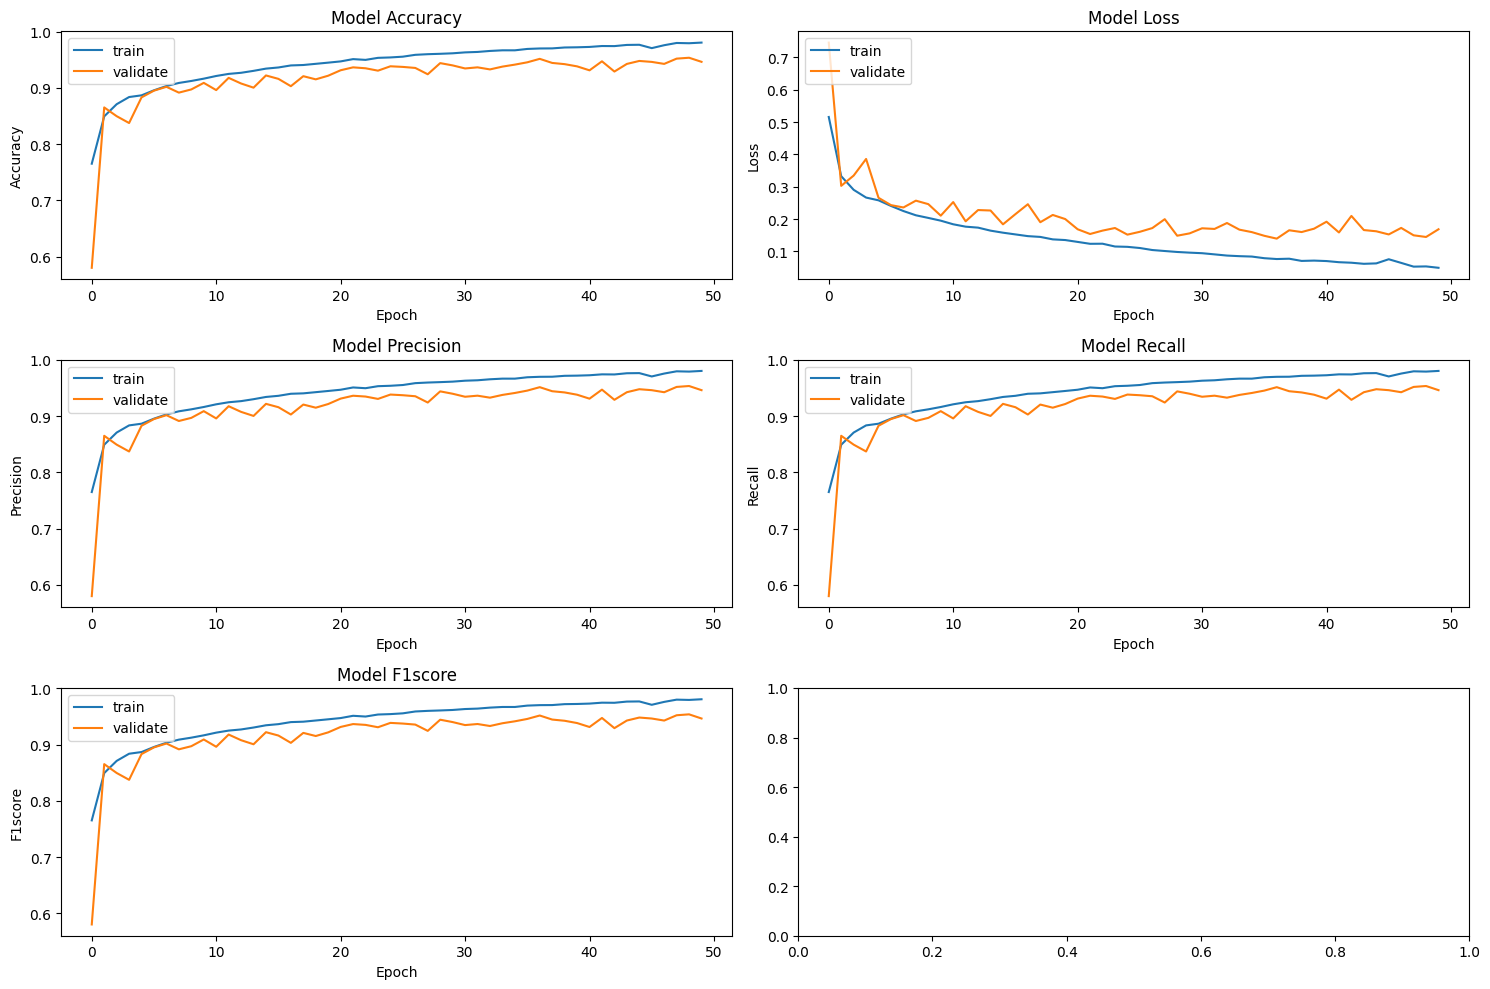

In [14]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [15]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  0.4786553680896759
Accuracy of test set is:  0.8626356720924377
F1score of test set is:  0.8626356720924377
Precision of test set is:  0.8626356720924377
Recall of test set is:  0.8626356720924377


### Draw confusion matrix

In [16]:
label

array(['right thumb', 'left thumb'], dtype='<U11')

In [17]:
labels = list(label)
labels

['right thumb', 'left thumb']

1911/1911 [==============================] - 7s 3ms/step


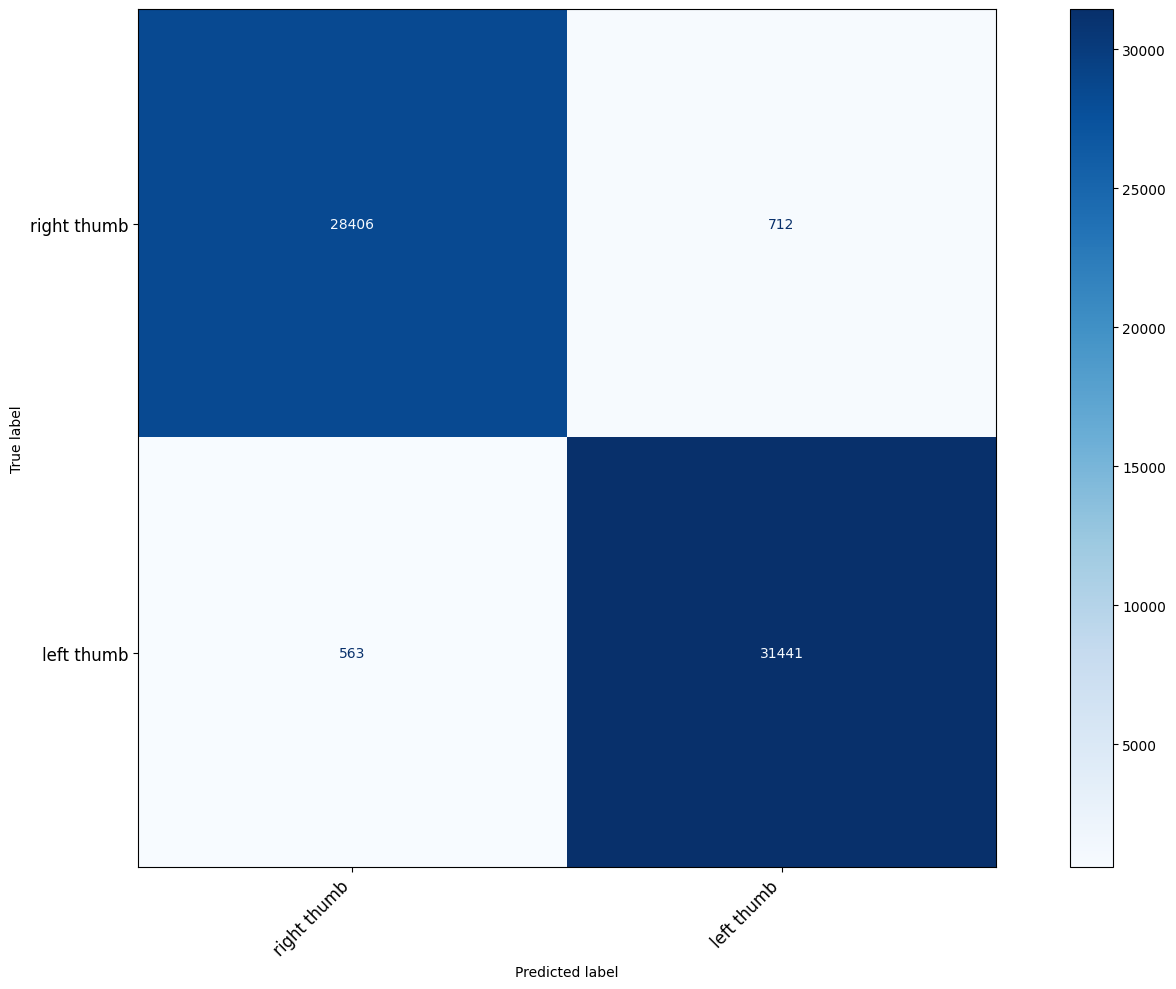

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [19]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((61122, 32, 32, 1), (61122, 2), (19168, 32, 32, 1), (19168, 2))

599/599 [==============================] - 2s 3ms/step


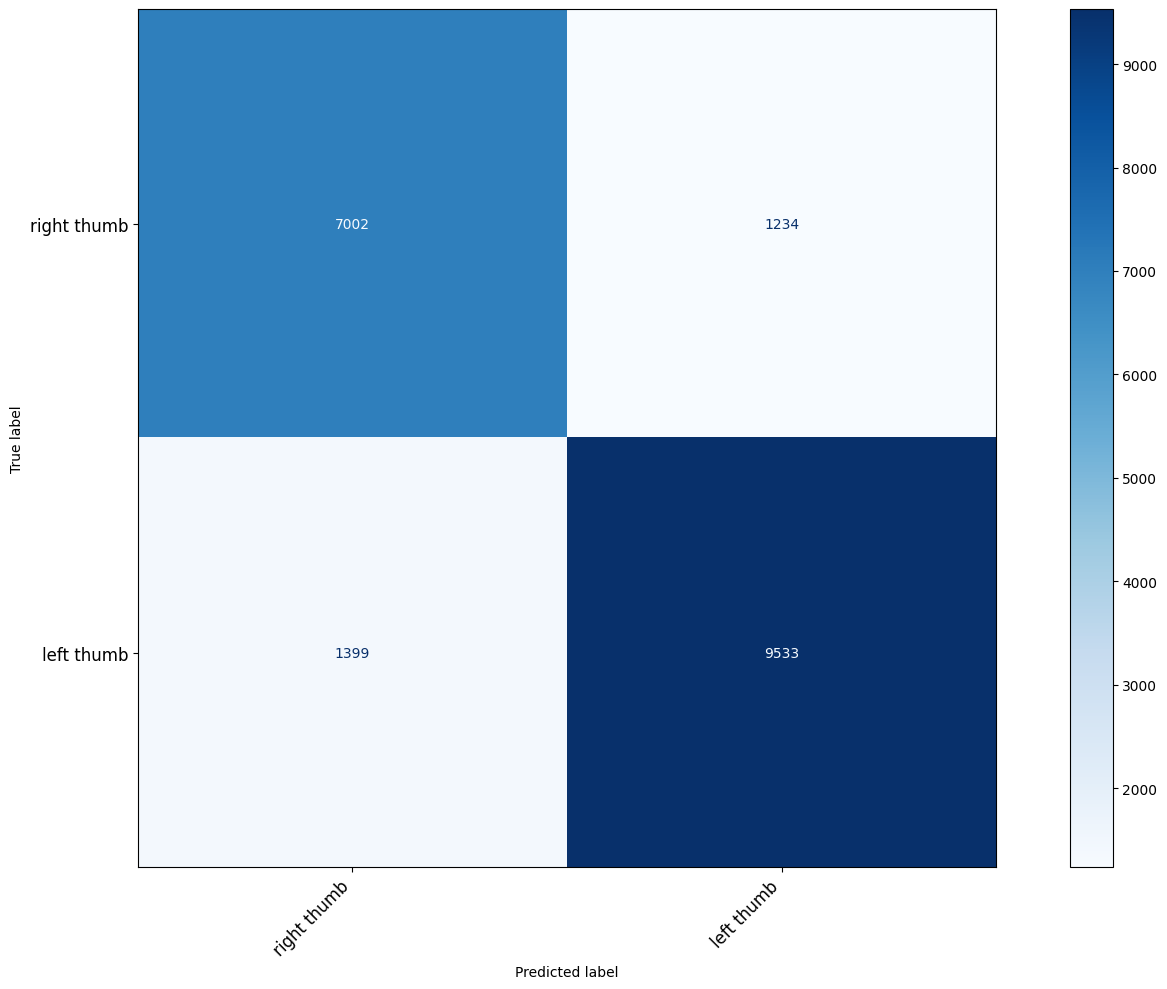

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()
